In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp

## When differentiating with respect to the first parameter is not enough

In [3]:
def dist(order, x, y):
  return jnp.power(jnp.sum(jnp.abs(x-y)**order), 1.0/order)

In [4]:
dist_d_x = jax.grad(dist, argnums=1) 

In [5]:
dist_d_xy = jax.grad(dist, argnums=(1,2)) 

In [6]:
dist_d_x(1, jnp.array([1.0,1.0,1.0]), jnp.array([2.0,2.0,2.0]))


DeviceArray([-1., -1., -1.], dtype=float32)

In [7]:
dist_d_xy(1, jnp.array([1.0,1.0,1.0]), jnp.array([2.0,2.0,2.0]))

(DeviceArray([-1., -1., -1.], dtype=float32),
 DeviceArray([1., 1., 1.], dtype=float32))

## Differentiating with respect to multiple parameters

In [12]:
x = np.linspace(0, 10*np.pi, num=1000)
e = np.random.normal(scale=10.0, size=x.size)
y = 65.0 + 1.8*x + 40*np.cos(x) + e 

xt = jnp.array(x)
yt = jnp.array(y)
learning_rate = 1e-2

In [13]:
model_parameters = {
    'w': jnp.array([1.]),
    'b': jnp.array([1.])
    }

def model(param_dict, x):
    w, b = param_dict['w'], param_dict['b']
    return w * x + b

def loss_fn(model_parameters, x, y):
    prediction = model(model_parameters, x)
    return jnp.mean((prediction-y)**2)

grads_fn = jax.grad(loss_fn)
grads = grads_fn(model_parameters, xt, yt)


In [14]:
print(grads)

{'b': DeviceArray([-153.65527], dtype=float32), 'w': DeviceArray([-2554.9482], dtype=float32)}


## Returning auxiliary data from a function

In [15]:
model_parameters = jnp.array([1., 1.])

def model(theta, x):
    w, b = theta
    return w * x + b

def loss_fn(model_parameters, x, y):
    prediction = model(model_parameters, x)
    return jnp.mean((prediction-y)**2), prediction

grads_fn = jax.grad(loss_fn, has_aux=True)
grads, preds  = grads_fn(model_parameters, xt, yt)
model_parameters -= learning_rate * grads


In [16]:
model_parameters

DeviceArray([26.549482 ,  2.5365527], dtype=float32)

In [17]:
grads

DeviceArray([-2554.9482 ,  -153.65527], dtype=float32)

In [18]:
preds.shape

(1000,)

## Obtaining both gradient and value of the function

In [19]:
model_parameters = jnp.array([1., 1.])

def model(theta, x):
    w, b = theta
    return w * x + b

def loss_fn(model_parameters, x, y):
    prediction = model(model_parameters, x)
    return jnp.mean((prediction-y)**2), prediction

grads_fn = jax.value_and_grad(loss_fn, has_aux=True)
(loss, preds), grads  = grads_fn(model_parameters, xt, yt)
model_parameters -= learning_rate * grads


In [20]:
loss

DeviceArray(6865.2383, dtype=float32)

In [21]:
preds.shape

(1000,)

In [22]:
grads

DeviceArray([-2554.9482 ,  -153.65527], dtype=float32)

## Higher-order derivatives

In [23]:
def f(x):
    return x**4 + 12*x + 1/x

f_d1 = jax.grad(f)
f_d2 = jax.grad(f_d1)
f_d3 = jax.grad(f_d2)

x = 11.0

print(f_d1(x))
print(f_d2(x))
print(f_d3(x))


5335.9917
1452.0015
263.9996


In [24]:
f_d3 = jax.grad(jax.grad(jax.grad(f)))

print(f_d3(x))

263.9996


Displaying several derivatives:

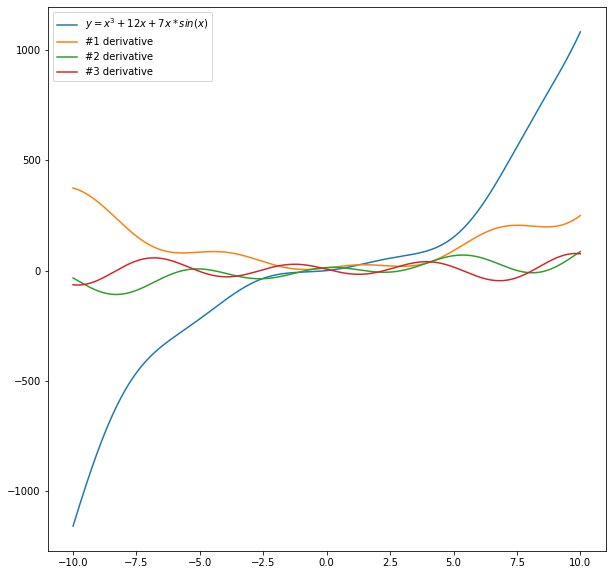

In [25]:
def f(x):
    return x**3 + 12*x + 7*x*jnp.sin(x)

x = np.linspace(-10, 10, num=500)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, f(x), label = r"$y = x^3 + 12x + 7x*sin(x)$")

df = f
for d in range(1,4):
  df = jax.grad(df)
  #ax.plot(x, (df)(x), label=f'#{d} derivative')
  ax.plot(x, jax.vmap(df)(x), label=f'#{d} derivative')
  ax.legend()

# Jacobians

In [26]:
def f(x):
  return [
      x[0]**2 + x[1]**2 - x[1]*x[2],
      x[0]**2 - x[1]**2 + 3*x[0]*x[2]
  ]  

In [27]:
print(jax.jacrev(f)(jnp.array([3.0, 4.0, 5.0])))

[DeviceArray([ 6.,  3., -4.], dtype=float32), DeviceArray([21., -8.,  9.], dtype=float32)]


In [28]:
print(jax.jacfwd(f)(jnp.array([3.0, 4.0, 5.0])))

[DeviceArray([ 6.,  3., -4.], dtype=float32), DeviceArray([21., -8.,  9.], dtype=float32)]


In [29]:
%timeit -n 100 jax.jacrev(f)(jnp.array([3.0, 4.0, 5.0]))

23.8 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%timeit -n 100 jax.jacfwd(f)(jnp.array([3.0, 4.0, 5.0]))

14.8 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Hessian

In [31]:
def f(x):
  return x[0]**2 - x[1]**2 + 3*x[0]*x[2]

In [32]:
jax.hessian(f)(jnp.array([3.0, 4.0, 5.0]))

DeviceArray([[ 2.,  0.,  3.],
             [ 0., -2.,  0.],
             [ 3.,  0.,  0.]], dtype=float32)

In [33]:
jax.jacfwd(jax.grad(f))(jnp.array([3.0, 4.0, 5.0]))

DeviceArray([[ 2.,  0.,  3.],
             [ 0., -2.,  0.],
             [ 3.,  0.,  0.]], dtype=float32)

In [34]:
jax.jacfwd(jax.grad(f))(jnp.array([3.0, 4.0, 5.0]))

DeviceArray([[ 2.,  0.,  3.],
             [ 0., -2.,  0.],
             [ 3.,  0.,  0.]], dtype=float32)

# JVP

Code for checking manual computations

In [44]:
def f(x1,x2):
  return x1*x2 + jnp.sin(x1*x2)

In [45]:
x = (7.0, 2.0)

In [46]:
f(*x)

DeviceArray(14.990607, dtype=float32, weak_type=True)

In [47]:
jax.grad(f)(*x)

DeviceArray(2.2734745, dtype=float32, weak_type=True)

In [48]:
jax.grad(f, argnums=(0,1))(*x)

(DeviceArray(2.2734745, dtype=float32, weak_type=True),
 DeviceArray(7.9571605, dtype=float32, weak_type=True))

JVP example

In [67]:
def f2(x):
  return [
      x[0]**2 + x[1]**2 - x[1]*x[2],
      x[0]**2 - x[1]**2 + 3*x[0]*x[2]
  ]  

x = jnp.array([3.0, 4.0, 5.0])
v = jnp.array([1.0, 1.0, 1.0])

In [69]:
p,t = jax.jvp(f2, x, v)

TypeError: ignored

In [68]:
p,t = jax.jvp(f2, (x,), (v,))

In [51]:
p

[DeviceArray(5., dtype=float32), DeviceArray(38., dtype=float32)]

In [52]:
t

[DeviceArray(5., dtype=float32), DeviceArray(22., dtype=float32)]

In [53]:
p,t = jax.jvp(f2, (x,), (jnp.array([1.0, 0.0, 0.0]),))
t

[DeviceArray(6., dtype=float32), DeviceArray(21., dtype=float32)]

In [54]:
p,t = jax.jvp(f2, (x,), (jnp.array([0.0, 1.0, 0.0]),))
t

[DeviceArray(3., dtype=float32), DeviceArray(-8., dtype=float32)]

In [55]:
p,t = jax.jvp(f2, (x,), (jnp.array([0.0, 0.0, 1.0]),))
t

[DeviceArray(-4., dtype=float32), DeviceArray(9., dtype=float32)]

Checking manual computations with jvp()

In [61]:
def f(x1,x2):
  return x1*x2 + jnp.sin(x1*x2)

x = (7.0, 2.0)

p,t = jax.jvp(f, x, (1.0, 0.0))

In [62]:
p

DeviceArray(14.990607, dtype=float32, weak_type=True)

In [63]:
t

DeviceArray(2.2734745, dtype=float32, weak_type=True)

# VJP

In [71]:
def f(x1,x2):
  return x1*x2 + jnp.sin(x1*x2)

x = (7.0, 2.0)

p,vjp_func = jax.vjp(f, *x)

In [72]:
p

DeviceArray(14.990607, dtype=float32, weak_type=True)

In [75]:
vjp_func(1.0)

(DeviceArray(2.2734745, dtype=float32, weak_type=True),
 DeviceArray(7.9571605, dtype=float32, weak_type=True))

In [76]:
vjp_func(2.0)

(DeviceArray(4.546949, dtype=float32, weak_type=True),
 DeviceArray(15.914321, dtype=float32, weak_type=True))

More complicated function

In [77]:
def f2(x):
  return [
      x[0]**2 + x[1]**2 - x[1]*x[2],
      x[0]**2 - x[1]**2 + 3*x[0]*x[2]
  ]  

x = jnp.array([3.0, 4.0, 5.0])

In [78]:
p,vjp_func = jax.vjp(f2, x)

In [79]:
p

[DeviceArray(5., dtype=float32), DeviceArray(38., dtype=float32)]

Restoring rows of the Jacobian

In [82]:
vjp_func([1.0, 0.0])

(DeviceArray([ 6.,  3., -4.], dtype=float32),)

In [83]:
vjp_func([0.0, 1.0])

(DeviceArray([21., -8.,  9.], dtype=float32),)